In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [25]:
using CSV, DataFrames, Plots, Colors

In [101]:
tum_blues = ["#D7E4F4", "#C2D7EF", "#9ABCE4", "#5E94D4", "#165DB1", "#14519A", "#114584", "#0E396E"]
tum_cgrad = cgrad(tum_blues)

In [ ]:
"""
    function plot_ll_heatmap(evals_df::DataFrame, cutoff::Int64, mle::Vector, prm_keys::Vector)

Plot of log-likelihood evaluations highlighting the MLE.

# Arguments
    - `evals_df::DataFrame`: Log-likelihood evaluations generated by `gen_ll_evals`
    - `cutoff::Int64`: Minimum value threshold; entries below this value are ignored (set to NaN)
    - `mle::Vector`: Maximum likelihood estimate of the two parameters (used to mark the best estimate)
    - `prm_keys::Vector`: Names of the two parameters corresponding to the rows and columns of `evals_df`
"""
function plot_ll(evals_df::DataFrame, cutoff::Int64, mle::Vector, prm_keys::Vector)

    if length(prm_keys)==2

        evals = Matrix(select(evals_df, names(evals_df, Number)))

        rx = range(0.0,2.0, length=size(evals,1))
        ry = range(0.0,2.0, length=size(evals,2))

        evals_cutoff = map(z -> z < cutoff ? NaN : z, evals)

        p = heatmap(rx, ry, evals_cutoff, alpha=0.9, xlabel=prm_keys[1], ylabel=prm_keys[2], title="Log-Likelihood", color=tum_cgrad, colorbar=false)
        contour!(rx, ry, evals_cutoff, linewidth=1, color=tum_cgrad, levels=300, label=false)
        scatter!([mle[1]],[mle[2]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="MLE")
    else
        rx = 0.0:0.01:2.0
        evals = evals_df[:,1]
        evals_cutoff = map(z -> z < cutoff ? NaN : z, evals)
        p = plot(rx, evals_cutoff, linewidth=2, color="#3070B3", xlabel=prm_keys[1], ylabel="", label="", title="Log-Likelihood")
        vline!([mle[1]], color="#F7811E", label="MLE", linestyle=:dash)
    end
    return p
end

plot_ll_heatmap

In [ ]:
# ersetzt gen_ll_evals_for_hprm_conb
"""
    function gen_ll_evals(prm_keys::Vector, hprm_true::Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=100.0)

Evaluates the log-likelihood evaluations of parameters for visualization or identifiability analysis.

# Arguments
    - `prm_keys::Vector`: Names of the two parameters to evaluate on the grid
    - `hprm_true::Hyperprm`: True hyperparameter values used to simulate data
    - `t_fixed::Bool=false`: True if a fixed observation time window is considered
    - `t_end::Float64=50.0`: End of the observation window (if t_fixed=true)
    - `t_step::Float64=1.0`: Step size for observations (if t_fixed=false)
    - `obs_late::Bool=false`: True if only late (stable state) observations are considered
    - `t_obs::Float64=100.0`: Time at which late observations are taken if `obs_late=true`

# Returns
    - A `DataFrame` containing the log-likelihood values over the 2D parameter grid
"""
function gen_ll_evals(prm_keys::Vector, hprm_true::Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=100.0)
    
    # create true data observations
    sol_true = Src.sol_klausmeier(hprm_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs) # returns df
    Src.randomize_data!(sol_true, hprm_true.noise)

    if length(prm_keys)==2
        grid = Src.create_grid()
        ll = zeros(size(grid, 1), size(grid, 2))
        for i in range(1, size(grid, 1))
            for j in range(1, size(grid, 2)) #eval for each point on grid
                pt = grid[i,j]
                ll[i,j] = Src.compute_ll([pt[1],pt[2]], prm_keys, hprm_true, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
            end
        end
        return DataFrame(ll,:auto)
    else
        xr = 0.0:0.01:2.0
        ll = zeros(length(xr))
        for i in range(1, length(xr))
            pt = xr[i]
            ll[i] = Src.compute_ll([pt[1]], prm_keys, hprm_true, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
        end
        return DataFrame(ll=ll)
    end
end

gen_ll_evals

In [ ]:
# TODO: ll grid plot
# TODO: notebook? for storing and reading in ll data for systematic grid plot
# TODO: add ll plot functionality to identifiability notebook -> maybe "analyze_ll" function erstellen.
# denke gen_all_ll_data ist unnötig

# TODO: all für fisher. redo it in julia simply. drop "gen_all_fish_data". do it manually. Q:? need to make grid coarser??? 
# hey, bright side is then i am on a really good way to a decent setup :)

In [216]:
a_true = 1.5
m_true = 0.45
prm_keys = [:a]

# further settings
t_fixed = true
hprm = Hyperprm(1.0, 1.0, a_true, m_true, 100, 0.1)

Hyperprm(1.0, 1.0, 1.5, 0.45, 100, 0.1)

In [217]:
ll_test = gen_ll_evals([:a], hprm, t_fixed=t_fixed);

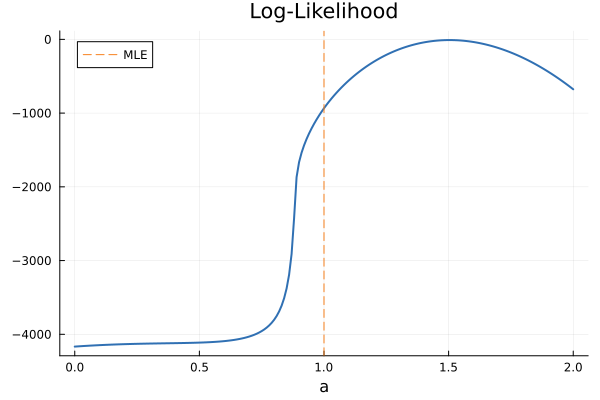

In [220]:
plot_ll_heatmap(ll_test, -10000, [1], [:a])